Reference: https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
batchSize = 8 # 64
imgHeight = 64
imgWidth = 64

# dataPath = "datasets/food-101/food-101/images/"
dataPath = "FastFood"

trainDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="training",
  color_mode = "rgb", 
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

valDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="validation",
  color_mode = "rgb",
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)




Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 7000 files belonging to 7 classes.
Using 1400 files for validation.


In [3]:
valBatch = tf.data.experimental.cardinality(valDataset)
testDataset = valDataset.take((2*valBatch) // 3)
valDataset = valDataset.skip((2*valBatch) // 3)

In [4]:
df = pd.read_csv('datasets/nutrition101 (1).csv')
protein_labels = list(df['protein'])
name_labels = list(df['name'])

In [5]:
def regression_dataset(data_list):
    def convt_labels(imgs, label):
        def convert_label(label):
            return np.array([data_list[int(y_i)] for y_i in label.numpy()])
        numeric_label = tf.py_function(convert_label, [label], tf.int32)
        return imgs, numeric_label
    return convt_labels

In [6]:
trainDataset = trainDataset.map(regression_dataset(protein_labels))
testDataset = testDataset.map(regression_dataset(protein_labels))
valDataset = valDataset.map(regression_dataset(protein_labels))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

trainDataset = trainDataset.cache().prefetch(buffer_size=AUTOTUNE)
valDataset = valDataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
numClasses = 101

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomCrop(128, 128, seed=123),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),

  # tf.keras.layers.Conv2D(32, 11, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(32, 5, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),


  # tf.keras.layers.Dropout(0.7),

  # tf.keras.layers.Flatten(),
  
  # tf.keras.layers.Dense(514, activation='sigmoid'),
  # tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1_l2(0.005))
])

In [9]:
learningRate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=learningRate,
    rho=0.9,
    momentum=0.1,
    epsilon=1e-07,
    centered=True
  ),
  loss=tf.keras.losses.MSE,
  metrics=['mse', 'mae'])

In [10]:
history = model.fit(
  trainDataset,
  validation_data=valDataset,
  epochs=30,
  callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="convNetFF.h5", verbose=1, save_best_only=True)]
)

Epoch 1/30


700/700 [==============================] - ETA: 0s - loss: 50.3870 - mse: 50.2966 - mae: 6.2877
Epoch 1: val_loss improved from inf to 49.10386, saving model to convNetFF.h5
700/700 [==============================] - 72s 84ms/step - loss: 50.3870 - mse: 50.2966 - mae: 6.2877 - val_loss: 49.1039 - val_mse: 49.0398 - val_mae: 6.0526
Epoch 2/30
700/700 [==============================] - ETA: 0s - loss: 46.4611 - mse: 46.3997 - mae: 6.0595
Epoch 2: val_loss improved from 49.10386 to 48.43786, saving model to convNetFF.h5
700/700 [==============================] - 57s 82ms/step - loss: 46.4611 - mse: 46.3997 - mae: 6.0595 - val_loss: 48.4379 - val_mse: 48.3793 - val_mae: 5.9312
Epoch 3/30
700/700 [==============================] - ETA: 0s - loss: 45.3610 - mse: 45.3043 - mae: 5.9865
Epoch 3: val_loss improved from 48.43786 to 48.03257, saving model to convNetFF.h5
700/700 [==============================] - 57s 81ms/step - loss: 45.3610 - mse: 45.3043 - mae: 5.9865 - val_loss: 48.0326 - val_

In [11]:
y_pred = model.predict(testDataset)
print(y_pred)
print(model.evaluate(testDataset))

116/116 [==============================] - 1s 10ms/step
[[ 7.153011  ]
 [11.045449  ]
 [11.020039  ]
 [11.183918  ]
 [ 7.8255463 ]
 [11.413982  ]
 [10.770381  ]
 [ 6.130726  ]
 [ 9.204437  ]
 [ 5.852164  ]
 [ 4.98709   ]
 [13.39761   ]
 [11.874645  ]
 [11.65836   ]
 [ 8.221602  ]
 [ 4.143916  ]
 [12.507011  ]
 [ 9.168571  ]
 [ 4.1008863 ]
 [13.087856  ]
 [ 6.5282993 ]
 [ 4.968896  ]
 [10.408052  ]
 [ 9.43554   ]
 [10.440002  ]
 [ 9.011291  ]
 [13.43043   ]
 [ 9.621747  ]
 [ 5.019118  ]
 [ 4.9531093 ]
 [ 6.0482388 ]
 [ 9.087719  ]
 [ 2.8061848 ]
 [ 4.178349  ]
 [ 7.699488  ]
 [ 7.370923  ]
 [13.442098  ]
 [ 9.7514105 ]
 [11.560176  ]
 [ 1.7748123 ]
 [ 8.534103  ]
 [ 4.17791   ]
 [12.122349  ]
 [10.804394  ]
 [ 4.5510206 ]
 [ 7.149662  ]
 [ 4.2061667 ]
 [ 5.107931  ]
 [ 7.1134267 ]
 [17.073196  ]
 [ 5.0702105 ]
 [ 4.06185   ]
 [13.410702  ]
 [ 4.8346114 ]
 [ 3.0227833 ]
 [ 9.812014  ]
 [10.607139  ]
 [ 9.88446   ]
 [ 5.4892516 ]
 [11.517839  ]
 [11.481825  ]
 [10.872173  ]
 [10.275171  ]

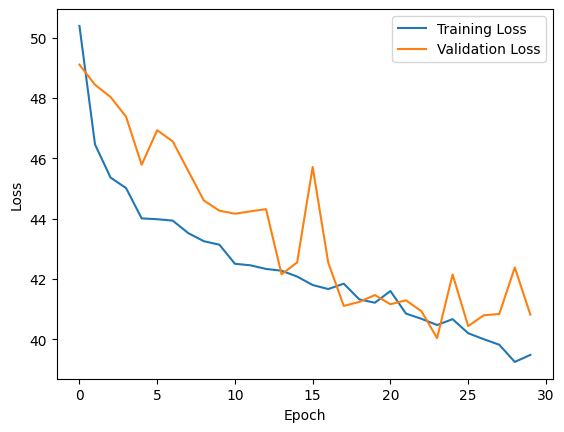

In [12]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save_weights("convNetFF.h5")